In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

In [77]:
sample_freq = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 10.0  # in dB

wm = ss.WirelessMicrophone(f_sample=sample_freq,
                           t_sec=length)  # either specify length in seconds
# wm = ss.WirelessMicrophone(f_sample=sample_freq, num_samples=1e5) # or number of samples

sig = wm.get_soft(f_center=1.e5, dB=signal_strength)
# sig += wm.get_soft(f_center=0.e5, dB=signal_strength)
# sig += wm.get_soft(f_center=-1.e5, dB=signal_strength)

# print('wm.f_sample:     %6.2f' % (wm.f_sample))
# print('wm.num_samples:  %9d' % (wm.num_samples))
# print('wm.t_sec:        %6.2f' % (wm.t_sec))

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq,
                            t_sec=length)  # either specify length in seconds
# wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length) # or number of samples
noise = wgn.get_signal(dB=noise_strength)

# print('wgn.f_sample:    %6.2f' % (wgn.f_sample))
# print('wgn.num_samples: %9d' % (wgn.num_samples))
# print('wgn.t_sec:       %6.2f' % (wgn.t_sec))

assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power:    %6.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:     %6.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:             %6.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Mean:            %6.2f ' % (np.abs(noise.mean())))
print('Var:             %6.2f ' % (np.abs(noise.var())))
print('Num Samples:     %9d ' % (num_samples))

Signal power:      0.00 dB
Noise power:      10.00 dB
SNR:             -10.00 dB
Mean:              0.00 
Var:              10.00 
Num Samples:       1000000 


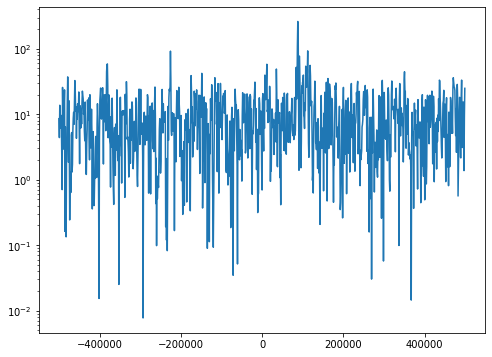

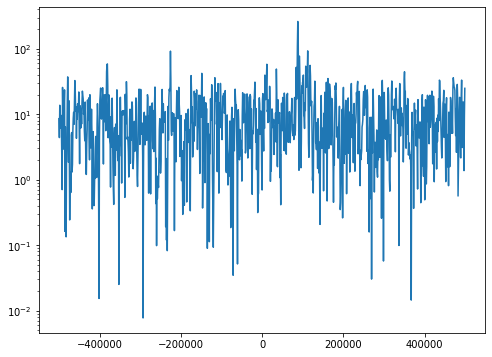

Energy signal 11120.586012047108
Snip energy 0.011120586012047108
Energy from psd 10845.856170965144
Energy from welch 10845.856170965146


In [131]:
which_snip = 2
snip = both[1024*which_snip:1024*(which_snip+1)]

sft = ss.Stft(n=1024, window='hann')
f, t, x = sft.spectogram(sig=snip, f_sample=sample_freq, normalized=False, dB=False)


psd = x[:, 0]
plt.figure(figsize=(8, 6))
plt.semilogy(f, psd)
# plt.semilogy(psd)
plt.show()


plt.figure(figsize=(8, 6))
from scipy import fft
f_welch, x_welch = signal.welch(snip,
                          sample_freq,
                          nperseg=1024,
                          noverlap=0,
                          window='hann',
                          scaling='density',
                          detrend=False)
f_welch = fft.fftshift(f_welch)
x_welch = fft.fftshift(x_welch) * sample_freq
# plt.plot(f_welch, x_welch)
plt.semilogy(f_welch, x_welch)
plt.show()

snip_length = (1./sample_freq)*1024
which_snip = 2
snip = both[1024*which_snip:1024*(which_snip+1)]

en_sig = ss.EnergyDetector.get(snip)
print(f'Energy signal {en_sig}')
# print(f'Energy signal real {1/sample_freq * en_sig}')

# print(f'Snip length {snip_length}')
print(f'Snip energy {ss.util.signal_energy(snip, snip_length)}')

print(f'Energy from psd {ss.util.get_energy_from_psd(psd)}')
print(f'Energy from welch {ss.util.get_energy_from_psd(x_welch)}')
# print(f'Power from psd {ss.util.get_power_from_psd(psd, f)}')

In [112]:
sft = ss.Stft(n=1024, window='flattop')

ratio_list = list()

for i in range(10):
    sig = wm.get_soft(f_center=1.e5, dB=signal_strength)
    noise = wgn.get_signal(dB=noise_strength)
    both = sig + noise
    
    which_snip = 2
    snip = both[1024*which_snip:1024*(which_snip+1)]
    en_sig = ss.EnergyDetector.get(snip)
    
    
    f, t, x = sft.spectogram(sig=snip, f_sample=sample_freq, normalized=False, dB=False)
    psd = x[:, 0]

    en_psd = ss.util.get_energy_from_psd(psd)
    en_psd_lower = ss.util.get_energy_from_psd(psd[0:512])
    en_psd_upper = ss.util.get_energy_from_psd(psd[512:1024])
#     print(f'Energy signal {en_sig}')
#     print(f'Energy from psd {en_psd}')
    
#     ratio = en_sig/en_psd
    ratio = en_sig/(en_psd_lower+en_psd_upper)
    ratio_list.append(ratio)
#     print(ratio)
    if i % 10 == 0:
        print(i)
    
np.sum(ratio_list)/10


0


1.0190661831128085

In [73]:
class FreqEnergyDetector():

    def __init__(self, num_bands=8, f_sample=1e6, fft_len=1024, freqs=None):
        self.num_bands = num_bands  # number of bands
        self.f_sample = f_sample  # sample rate used with the
        self.fft_len = fft_len  # length of the fft used to compute the power spectrum
        self.freqs = freqs  # frequency band, x axis, used by the power spectrum
        self.di = fft_len / num_bands  # calculate the points per band
        self.df = freqs[1] - freqs[0]  # calculate the frequency width per band
        assert np.isclose(self.df, (self.f_sample / self.fft_len))

    def segs(self, ps):
        f_segs = list()
        ps_segs = list()
        for i in range(int(self.num_bands)):
            idx1 = int(i * self.di)
            idx2 = int((i + 1) * self.di)
            f_segs.append(self.freqs[idx1:idx2])
            ps_segs.append(ps[idx1:idx2])
        return f_segs, ps_segs

    def detect(self, ps):
        f_segs, ps_segs = self.segs(ps)
        return list(map(lambda x: np.sum(x), ps_segs))


fe = FreqEnergyDetector(num_bands=2, f_sample=sample_freq, fft_len=1024, freqs=f)
fe.detect(psd)

[512.467544779601, 1483.3383034916533]

In [21]:
# Plot the resulting signals using matplotlib

# plt.figure(figsize=(8, 6))
# plt.specgram(noise,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.specgram(sig,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.specgram(both,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()